# Preprocessing and Modeling

In [58]:
import requests, json, time, re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
df_all = pd.read_csv('../datasets/df_all.csv', lineterminator='\n', index_col = False)

In [3]:
df_all.head()

,Unnamed: 0,title,selftext,all,in,all_clean,all_tokenized,all_lemm,all_stem,char_count,word_count
0,0,Delicious Blue Bottle Coffee,,Delicious Blue Bottle Coffee,0,delicious blue bottle coffee,"['delicious', 'blue', 'bottle', 'coffee']",delicious blue bottle coffee,delici blue bottl coffe,28,4
1,1,PSA: Looking for an inexpensive alternative to...,,PSA: Looking for an inexpensive alternative to...,0,psa: looking for an inexpensive alternative to...,"['psa', 'looking', 'for', 'an', 'inexpensive',...",psa looking for an inexpensive alternative to ...,psa look for an inexpens altern to a dedic goo...,121,18
2,2,Is there a feasible way to store coffee for lo...,I just received two 2 pound bags of coffee for...,Is there a feasible way to store coffee for lo...,0,is there a feasible way to store coffee for lo...,"['is', 'there', 'a', 'feasible', 'way', 'to', ...",is there a feasible way to store coffee for lo...,is there a feasibl way to store coffe for long...,371,72
3,3,A shot in the dark (name that coffee),I want to get some coffee for a very left-lean...,A shot in the dark (name that coffee) I want t...,0,a shot in the dark (name that coffee) i want t...,"['a', 'shot', 'in', 'the', 'dark', 'name', 'th...",a shot in the dark name that coffee i want to ...,a shot in the dark name that coffe i want to g...,300,57
4,4,[Serious question] How can I keep drinking cof...,This isn't a joke at all. I'm 100% serious. I ...,[Serious question] How can I keep drinking cof...,0,[serious question] how can i keep drinking cof...,"['serious', 'question', 'how', 'can', 'i', 'ke...",serious question how can i keep drinking coffe...,seriou question how can i keep drink coffe wit...,439,92


In [4]:
df_all.drop(columns = 'Unnamed: 0', inplace = True)

In [23]:
df_all.fillna(' ', inplace = True)

## Model Preparation

In [24]:
X = df_all[['all_lemm']]
y = df_all['in']

Train test split should be performed before proceeding with modeling techniques

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

Stratified to ensure that when train_test splitting, I maintain the same percentage of X and y.

### TF-IDF

In [26]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.append('ve')
custom_stop_words.append('wa')
custom_stop_words.append('just')
custom_stop_words.append('don')
custom_stop_words.append('amp')
custom_stop_words.append('gt')

In [27]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        stop_words = custom_stop_words, 
                        min_df = 15, 
                        max_df = 1.0)

min_df will remember words that are in a document at least once. For example,
if min_df = 15, will only remember words that are a part of 15 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [30]:
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train['all_lemm']).todense(), ##todense is 'expanding' the compressed version (adding 0's)
                          columns = tfidf.get_feature_names()) 

In [31]:
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test['all_lemm']).todense(), ##todense is 'expanding' the compressed version (adding 0's)
                          columns = tfidf.get_feature_names()) 

In [32]:
X_train_tfidf.shape

(24033, 7962)

In [33]:
X_test_tfidf.shape

(8012, 7962)

### Baseline model

In [34]:
df_all['in'].value_counts(normalize=True)

1    0.56274
0    0.43726
Name: in, dtype: float64

The baseline model can be interpreted as the following: this particular model will predict the majority class in 100% of the occassion with 56.3% accuracy. The baseline model as the name hints is a rudimentary model that may not classify results with the highest accuracy. Further models will be explored to outperform the baseline model. 

## Further Models

For many of models to be fitted and explored, below are some rationale/explanations on hyperparmeters chosen: <br>
- ngram_range = (1,2): to maintain the integrity of word combinations, I will specify an ngram_range of (1,2) to ensure I retain context of certain words. <br>
- stop_words: A custom stop words list was created after initial data exploration that certain words were inserting too much noise. <br>
- min_df = 10 : will remember words that are are a part of 10 documents in a corpus. <br>
- max_df = 1.0 : if a word occurs in more than 100% of the documents in my corpus, ignore it.

Mentioned earlier in the eda notebook, I will also explore the models on the TFIDF'ed version because it penalizes common words and gives infrequent words more weight. <br> The weight is a statistical measure used to evaluate how important a word is to a document in a corpus.

### Naive Bayes 

The naive Bayes algorithm uses the probability of boserving predictor values, given an outcome, to estimate the probability of observing outcome Y = i, given a set of predictor values. 

#### Naive Bayes on Tfidf

In [35]:
from sklearn.naive_bayes import MultinomialNB

In [36]:
nb = MultinomialNB()

In [37]:
model = nb.fit(X_train_tfidf, y_train)

In [38]:
predictions = model.predict(X_test_tfidf)

In [39]:
model.score(X_train_tfidf, y_train)

0.6863063287979029

In [40]:
model.score(X_test_tfidf, y_test)

0.6058412381427858

The Naive Bayes model (0.6058) performed better than the baseline (56.3%) model. We see evidence of overfitting to our training dataset. We will continue to explore other models to improve upon this score.

## Logistic Regression

#### LogReg on Tfidf

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
lr = LogisticRegression()

- Penalty: l1 (lasso) or l2 (ridge) regularization
- C: Inverse of regularization strength. The greater its value, the weaker the regularization strength is.

In [92]:
lr_params = {'C': [0.5, 1, 2],
             'penalty' : ['l1','l2']}

In [93]:
gs_lr = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr.fit(X_train_tfidf, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

0.6544048883438989


{'C': 1, 'penalty': 'l1'}

In [45]:
gs_lr.score(X_test_tfidf, y_test)

0.6607052017068411

Setting up a pipeline of C and penalty of l1 and l2 (lasso and ridge, respectively), the gridsearch provided the optimal hyperparameters of C: 0.5 and penalty of 'l1'. With the calculated hyperparameters, the optimal test score came out to be 0.6607, an improvement from the naive bayes model. There also seems to be very little evidence of overfitting to our training dataset. The logistic regression may be best for model interpretation and hence will be considered for production. 

In [46]:
gs_lr_coef_tfidf_df = pd.DataFrame(gs_lr.best_estimator_.coef_, columns = X_train_tfidf.columns).T

In [47]:
gs_lr_coef_tfidf_df.columns = ['weights']

In [48]:
gs_lr_coef_tfidf_df['odds'] = np.exp(gs_lr_coef_tfidf_df['weights'])

In [49]:
gs_lr_coef_tfidf_df['abs_weights'] = np.abs(gs_lr_coef_tfidf_df['weights'])

In [50]:
gs_lr_coef_tfidf_df['abs_weights'] = np.abs(gs_lr_coef_tfidf_df['weights'])

In [51]:
gs_lr_coef_tfidf_df.sort_values(ascending=False, by='abs_weights').head(15)

,weights,odds,abs_weights
edit,-4.444256,0.011746,4.444256
aergrind,3.203042,24.607281,3.203042
sette,2.769606,15.952351,2.769606
feld,2.556109,12.885584,2.556109
moccamaster,2.147465,8.563121,2.147465
hi,2.071224,7.934530,2.071224
helor,1.981467,7.253379,1.981467
tea,1.950813,7.034401,1.950813
stumptown,-1.924605,0.145933,1.924605
recommendation,1.922607,6.838764,1.922607


In [52]:
gs_lr_coef_tfidf_df.sort_values(ascending=False, by='weights').head(15)

,weights,odds,abs_weights
aergrind,3.203042,24.607281,3.203042
sette,2.769606,15.952351,2.769606
feld,2.556109,12.885584,2.556109
moccamaster,2.147465,8.563121,2.147465
hi,2.071224,7.934530,2.071224
helor,1.981467,7.253379,1.981467
tea,1.950813,7.034401,1.950813
recommendation,1.922607,6.838764,1.922607
kinu,1.711162,5.535387,1.711162
pro,1.585425,4.881363,1.585425


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text yticklabel objects>)

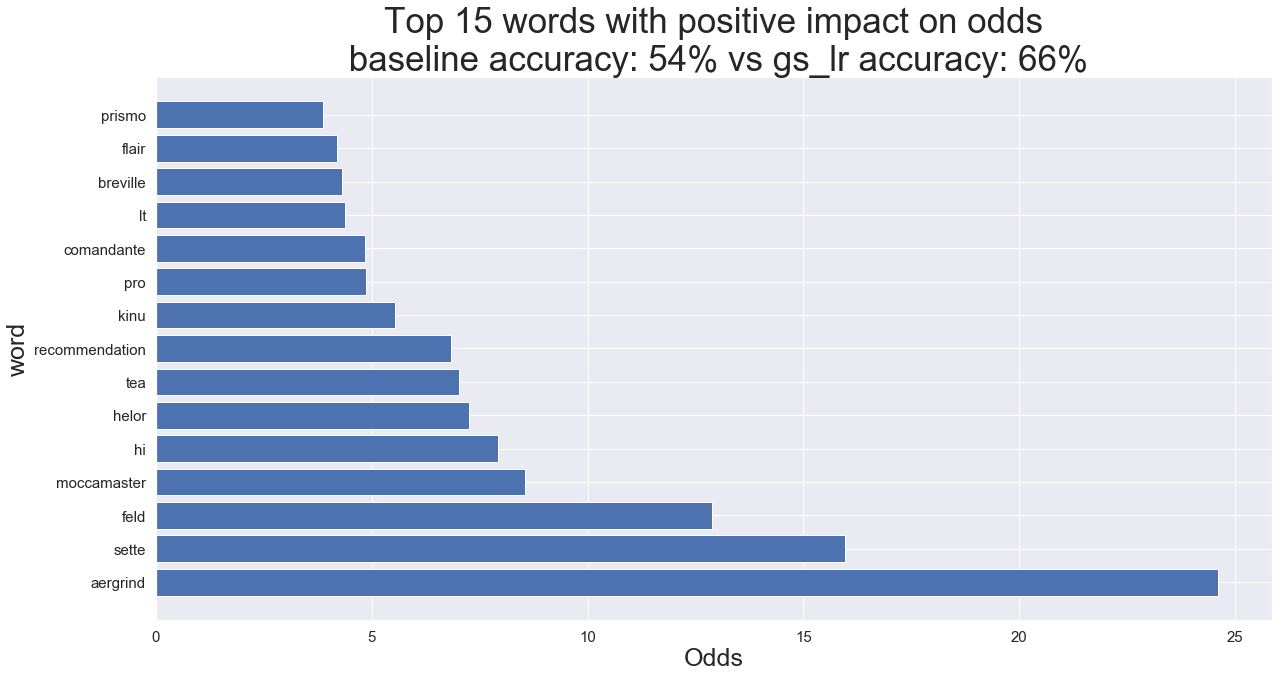

In [53]:
plt.figure(figsize=(20,10))
temp = gs_lr_coef_tfidf_df.sort_values('odds', ascending = False).head(15)
plt.barh(temp.index, temp['odds'])
plt.title('Top 15 words with positive impact on odds\n baseline accuracy: 54% vs gs_lr accuracy: 66%', fontsize=35)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('word', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

The above chart can be interpreted as the following: if a post includes words such as 'sette, moccamaster', the odds of the post being classified into the positive class  (recall that the positive class for this analysis is being trendy/'in' or in 2017) is ~16 and ~9 times as likely, respectively.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text yticklabel objects>)

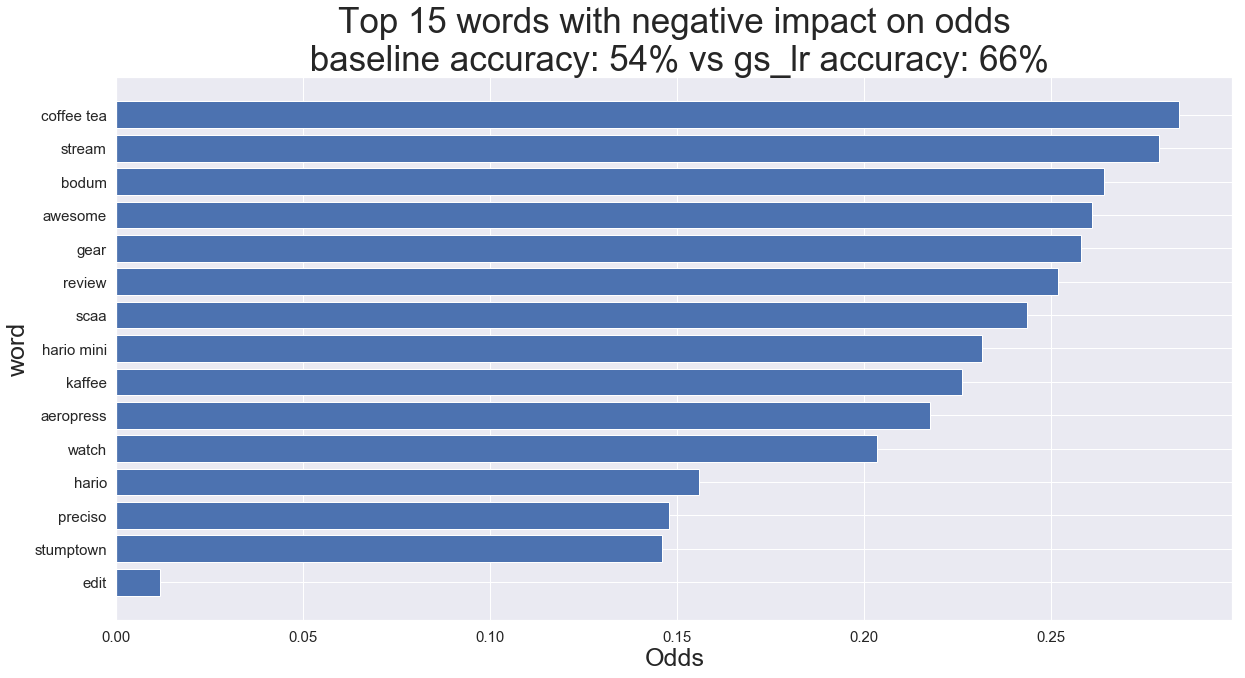

In [54]:
plt.figure(figsize=(20,10))
temp = gs_lr_coef_tfidf_df.sort_values('odds', ascending = True).head(15)
plt.barh(temp.index, temp['odds'])
plt.title('Top 15 words with negative impact on odds\n baseline accuracy: 54% vs gs_lr accuracy: 66%', fontsize=35)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('word', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Contrary to the previous chart, the above chart displays the decrease in likelihood being classified into the positive class. For example, if posts include the words 'hario' or 'hario mini', the odds of being classified into the positive class is ~0.15 and ~0.23 as likely. 

In [56]:
lr_pred = gs_lr.predict(X_test_tfidf)

### Classification Metrics

One of the core metrics for a classification problem is a confusion matrix

In [60]:
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred = lr_pred),
            index = ['Actual Negative', 'Actual Positive'],
            columns = ['Predicted Negative', 'Predicted Positive'])

,Predicted Negative,Predicted Positive
Actual Negative,1386,2117
Actual Positive,919,3590


- Predicted Negative: We predicted that the post came from the year 2015
- Predicted Positive: We predicted that the post came from the year 2017
- Actual Negative: The post was actually from 2015
- Actual Positive: The post was actually from 2017

With this confusion matrix, a helpful metric to be able to classify is precision which measures the accuracy of a predicted positive outcome. This can be interpreted as the following: 'We correctly predicted that a post came from 2017'. Precision is calculated by the following: <br>
- True Positive / (True Positive + False Positive)
- 3590 / (3590 + 2117) = .629

Another form of metric is accuracy which measures the rate with which we predicted correctly the origins of a post. It is defined by the following: 
- (True Positive + True Negatives)/ (TP + TN + FP + FN)
- (3590 + 1386) / (3590 + 1386 + 2117 + 919) = 4976/8012 = .621

### Explore certain posts that we classfied 

#### Posts confidently predicted correctly

In [90]:
X_test[(gs_lr.predict_proba(X_test_tfidf)[:, 1] > .75) & (y_test == 1)].head()

,all_lemm
29566,coffee version of shop like david s tea i m re...
22993,fellow stagg ekg electric kettle worth every p...
29981,cheap grinder for espresso hi all recently got...
15246,using the gaggia classic what is the best fast...
30766,v troubleshooting with julio melendez geisha g...


In [88]:
X_test['all_lemm'].loc[15633]

'steaming the shot in with plant based milk i m currently spending some time in the u k and i m finding it common to see barista s mixing the shot in with plant based milk then steaming them together can anyone explain to me the reason logic behind this thank you'

In [89]:
X_test['all_lemm'].loc[7339]

'fast manual grinder i m looking for a manual burr grinder that doesn t take ton of rotation to grind whole bean other than the one that cost i ve not been able to find one that doesn t take forever to grind enough for several cup i assume to make the grinding easier for the average person i don t mind if turning the handle take some elbow grease i just want to get the stuff ground quickly doe anyone have any suggestion'

#### Predicted confidently predicted incorrectly

In [91]:
X_test[(gs_lr.predict_proba(X_test_tfidf)[:, 1] > .75) & (y_test != 1)].head()

,all_lemm
7380,help single basket espresso on e i just purcha...
2719,is it worth it second hand technivorm moccamas...
2106,cunill brazil burr hey everyone i got a cunill...
13081,small super automatic espresso machine could a...
698,i just found out something interesting about c...


#### Posts predicted incorrectly with low confidence

In [74]:
X_test[(gs_lr.predict_proba(X_test_tfidf)[:, 1] > .50) & 
       (gs_lr.predict_proba(X_test_tfidf)[:, 1] < .55) & 
       (y_test != 1)].head(10)

,all_lemm
13339,every time i drink coffee from one particular ...
11296,where can i find a travel mug with a nozzle i ...
5486,heat up the sand and make a coffee video
4473,weighing coffee at work i ve seen a few post a...
1787,this just showed up at my starbucks do i dare ...
12876,anybody ever try egg nog a a creamer for coffe...
13224,how to make cold brewed coffee
10093,can someone give me the tl dr on cold brew cof...
3863,my favorite coffee song
6944,dave grohl foo fighter is a fellow coffee lover


#### Posts predicted correctly with low confidence

In [75]:
X_test[(gs_lr.predict_proba(X_test_tfidf)[:, 1] > .50) & 
       (gs_lr.predict_proba(X_test_tfidf)[:, 1] < .55) & 
       (y_test == 1)].head(10)

,all_lemm
24067,sing along the best part of waking up is choc ...
31219,got pretty lucky at the thrift store today wor...
24008,best coffee scene which canadian town or city ...
21543,bought a gb
29388,professional alternative to pearl scale hey gu...
20276,boston event ben carlson of longmilescoffeepro...
25569,best of chi town headed to chicago from san di...
30869,pretty happy with the shot i m getting with my...
24193,why aeropress chemex or espro coffee breakdown...
18788,limited edition coffee thermos limited time di...


## Random Forest

Random Forest model was explored because it addresses a problem with bagged decision trees, mainly that the trees are strongly correlated with each other and therefore higher variance. Instead, we will 'de-correlate' our trees to lower our variance while only increasing our bias marginally. <br>

Instantiated a GridSearchCV for RandomForestClassifier

In [76]:
RandomForestClassifier(random_state = 42)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

- `n_estimators`: Number of trees our model builds before taking an average of the predictions. Increasing the number of trees will allow our model to better learn the data, but having too much can slow down the process considerably.
- `min_samples_split`: Minimum number of samples required for a node to split
- `max_depth`: Maximum number of levels in each tree. As the value increases, so does the information captured. We include the default value of None in addition to our other values

In [78]:
params = {
    'n_estimators': [10, 25, 45],
    'min_samples_split': [3, 7, 13],
    'max_depth': [None, 3, 6, 9]}

In [79]:
gs = GridSearchCV(RandomForestClassifier(n_estimators = 100),
                 param_grid = params,
                 return_train_score = False,
                 cv = 3)
gs.fit(X_train_tfidf, y_train)
gs.score(X_train_tfidf, y_train)

0.9886822286023385

In [80]:
gs.score(X_test_tfidf, y_test)

0.6159510733899152

It is apparent that the random forest algorithm overfits very much to the training data.

In [81]:
gs.best_params_

{'max_depth': None, 'min_samples_split': 7, 'n_estimators': 45}

Through tuning our hyperparameters via gridsearch, we achieved a score of 0.988 using random forest tree model; however, our score on the test dataset is 0.62, performing worse than the logistic regression

In [82]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, X_train_tfidf.columns, columns = ['importance'])

In [83]:
feat_importance.head()

,importance
_______,1.020573e-07
aa,7.722447e-05
ability,4.965571e-05
able,8.767920e-04
able brew,1.678032e-05


Text(0, 0.5, 'Feature')

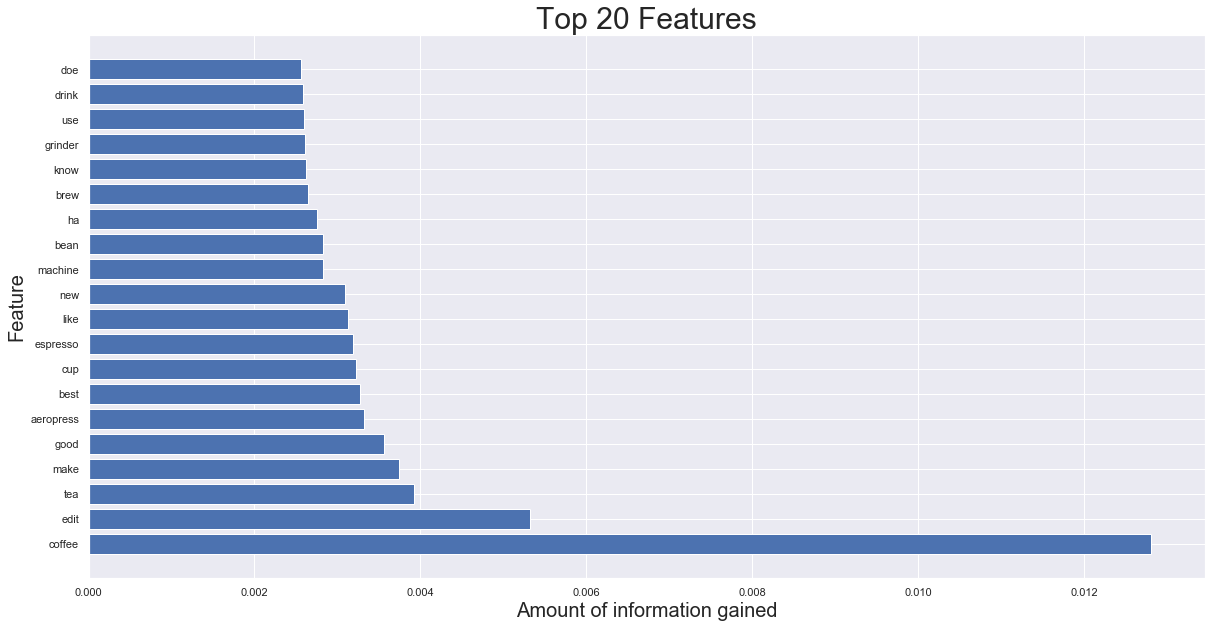

In [84]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

In [85]:
rf_pred = gs.predict(X_test_tfidf)

In [86]:
pd.DataFrame(confusion_matrix(y_true = y_test, 
                              y_pred = rf_pred),
             index=['Actual Negative', 'Actual Positive'],
             columns=['Predicted Negative', 'Predicted Positive'])

,Predicted Negative,Predicted Positive
Actual Negative,1308,2195
Actual Positive,882,3627


With this confusion matrix, a helpful metric to be able to classify is precision which measures the accuracy of a predicted positive outcome given by the following: <br>
- True Positive / (True Positive + False Positive)
- 3627 / (3627 + 2195) = .623

Another form of metric is accuracy which measures the rate with which we predicted correctly the origins of a post. It is defined by the following: 
- (True Positive + True Negatives)/ (TP + TN + FP + FN)
- (3627 + 1308) / (3627 + 1308 + 2195 + 882) = 4935/8012 = .615

Both the precision and accuracy metric performed slightly worse than the score from the logistic regression model (.629 and .621, respectively)

The top 5 words that produce the most amount of information gained in the split of the decision trees are ordered as the following: coffee, edit, tea, make and best. However, considering the scale of the x-axis (max of ~0.011), the amount of information gained is not substantial to warrant random forest trees as a model to put into production.

**_From the above explored models, the model to be put into production will be the logistic regression due to its best performance of accuracy in predicting the true positives and negatives as well as its ease of interpretability_**